# OncodriveCLUSTL

### Import modules

In [1]:
%matplotlib inline
import os
from functools import partial
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor as Pool
from collections import namedtuple

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd

import oncodriveclustl as clst

### Automatically incorporates changes in the *oncodriveclusts* module 

In [2]:
%load_ext autoreload
%autoreload 2

### Configure the logger

In [3]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%H:%M:%S', level=logging.INFO)

### Global Variables

#### Equivalent to this command line:
    python oncodriveclustl.py 
        -r inputs/regions/02_cds.regions.gz 
        -w 51 
        -m subs 
        -n 100 
        -c 4 
        -e TP53 -e EEA1 
        inputs/mutations/Bladder-TCC.txt 
        outputs/Bladder-TCC.oncodriveclustl.tsv

In [4]:
NUM_SIMULATIONS = 100
INPUT_FILE = os.path.join('inputs', 'mutations', 'Bladder-TCC.txt')
OUTPUT_DIR = 'outputs'
OUTPUT_FILE = os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(INPUT_FILE))[0] + ".oncodriveclustl.tsv")
REGION_FILE = os.path.join('inputs', 'regions', '02_cds.regions.gz')
DRIVERS_FILE = os.path.join('inputs', 'CGCMay17_cancer_types_TCGA.tsv')
ELEMENTS = ['TP53', 'EEA1']  # None
WINDOW_SIZE = 51
MUTATION_TYPE = 'subs'
SIGNATURE = None
ABSOLUTE_MAX_PEAK = True
CORES = 4
DEBUG = True

In [5]:
Results = namedtuple('Results', ' '.join(['symbol', 'geneid', 'pvalues', 'pos_pvalues',
                                          'mutations', 'mutations_index', 'obs_max',
                                          'obs_peaks_values', 'obs_peaks_index', 'borders',
                                          'fragments', 'smoothed', 'num_mutations',
                                          'random_maxs']))

### Read the region file

In [6]:
%%time

elements = set([]) if ELEMENTS is None else set(ELEMENTS)
regions_tree, regions_dict = clst.build_regions(REGION_FILE, 'genomic', elements)
regions_names = set(regions_dict.keys())

if len(elements) > 0:
    for element in elements - regions_names:
        logger.warning('element %s not found', element)

19:57:41 INFO: Loading genomic regions...


CPU times: user 484 ms, sys: 0 ns, total: 484 ms
Wall time: 481 ms


### Tukey function

In [7]:
clst.tukey_filter = clst.tukey(WINDOW_SIZE)

### Read the mutations files

In [8]:
%%time

mutations = clst.map_mutations_to_regions(
    mutations_file=INPUT_FILE,
    regions_tree=regions_tree,
    mutation_type=MUTATION_TYPE
)

19:57:44 INFO: Mapping mutations ..


CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 1.68 s


In [9]:
# This is how the mutations look like
list(mutations.items())[:2]

[('EEA1',
  {Mutation(chromosome='12', position='93258690', ref='T', alt='C', sample='df8a913c-5160-4fc5-950d-7c890e24e820', type='subs', cancer_type='Bladder-TCC')}),
 ('TP53',
  {Mutation(chromosome='17', position='7577108', ref='C', alt='A', sample='b73523d7-f5a5-4140-8537-4df4d1ecf465', type='subs', cancer_type='Bladder-TCC'),
   Mutation(chromosome='17', position='7577127', ref='C', alt='T', sample='cda1a403-16b6-487c-a82a-c377d1d0f89d', type='subs', cancer_type='Bladder-TCC'),
   Mutation(chromosome='17', position='7577538', ref='C', alt='T', sample='4838b5a9-968c-4178-bffb-3fafe1f6dc09', type='subs', cancer_type='Bladder-TCC'),
   Mutation(chromosome='17', position='7577539', ref='G', alt='A', sample='2b142863-b963-4cc9-8f8f-c72503c93390', type='subs', cancer_type='Bladder-TCC'),
   Mutation(chromosome='17', position='7577568', ref='C', alt='A', sample='f389176f-d8f3-45c2-aae4-7378a3d6fc7f', type='subs', cancer_type='Bladder-TCC'),
   Mutation(chromosome='17', position='7578190'

### FInd clusters

In [10]:
results = {}
with Pool(max_workers=CORES) as executor, tqdm(total=len(mutations)) as pbar:
    fx = partial(
        clst.cluster_element,
        regions=regions_dict,
        num_simulations=NUM_SIMULATIONS,
        window_size=WINDOW_SIZE,
        signature=SIGNATURE,
        absolute_max_peak=ABSOLUTE_MAX_PEAK
    )
    map_method = map if DEBUG else executor.map
    for geneid, result in map_method(fx, mutations.items()):
        pbar.update(1)
        results[geneid] = Results(**result)

100%|██████████| 2/2 [00:00<00:00, 12.96it/s]


In [11]:
# This is how the results look like
results

{'EEA1': Results(symbol=None, geneid='EEA1', pvalues=[nan], pos_pvalues=array([ 1.,  1.,  1., ...,  1.,  1.,  1.]), mutations=[93258690], mutations_index=array([4042]), obs_max=0.036057697239255629, obs_peaks_values=[], obs_peaks_index=[], borders={(3435, 3591): (93244887, 93245043), (3591, 3713): (93245951, 93246073), (897, 1083): (93175726, 93175912), (4209, 4233): (93322819, 93322843), (340, 579): (93171717, 93171956), (1461, 1563): (93195376, 93195478), (120, 219): (93170620, 93170719), (0, 120): (93169790, 93169910), (3827, 3867): (93247691, 93247731), (765, 897): (93174056, 93174188), (1894, 2034): (93202793, 93202933), (2190, 2304): (93206756, 93206870), (579, 765): (93172891, 93173077), (3318, 3435): (93236241, 93236358), (1266, 1461): (93192668, 93192863), (2709, 2829): (93219942, 93220062), (3867, 3933): (93251051, 93251117), (219, 340): (93171319, 93171440), (2979, 3318): (93226288, 93226627), (2505, 2709): (93213084, 93213288), (1083, 1266): (93181643, 93181826), (2829, 297

### Plot of the clusters

In [12]:
def plot_clusters(symbol, results):
    """Graphical representation of the clusters"""
    with plt.style.context('default'):
        # Layout
        plt.figure(figsize=(9, 3))
        ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
        ax3 = plt.subplot2grid((1, 5), (0, 4))

        data = results[symbol]

        # Plot the smoothing
        ax1.plot(data.smoothed, c='cornflowerblue')
        length = len(data.smoothed)
        ax1.set_ylabel('cluster value', color='cornflowerblue')
        ax1.tick_params('y', colors='cornflowerblue')
        
        # Plot the pvalue of each position
        ax2 = ax1.twinx()
        fx = np.vectorize(lambda x: 1 / NUM_SIMULATIONS if x == 0 else x)
        x = fx(data.pos_pvalues)
        ax2.plot(-1 * np.log10(x), c='orange')
        ax2.set_ylabel('positional pvalue (-log10)', color='orange')
        ax2.tick_params('y', colors='orange')

        # Plot the significat cutoffs
        ax1.hlines(np.max(data.random_maxs), 0, length, colors='r', linestyles='dashed')
        ax1.hlines(np.mean(data.random_maxs), 0, length, colors='r', linestyles='dashed')
        ax1.hlines(np.min(data.random_maxs), 0, length, colors='r', linestyles='dashed')

        # Rug
        ax1.plot(data.mutations_index, np.zeros(len(data.mutations_index)), '|', ms=20)  # 'b+', [0.05] * len(data.mutations)

        # Title and limits
        ax1.set_title(symbol)
        ax1.set_xlim(0, length)
        ax1.set_ylim(0, max(max(data.smoothed), max(data.random_maxs)) * 1.1)
        ax2.set_ylim(0, ax2.get_ylim()[1])
        
        # Plot the borders
        for x in [k[1] for k in data.borders.keys()]:
            ax1.vlines(x, 0, ax1.get_ylim()[1], colors='grey', linestyles='dashed')
            # poly = Rectangle(xy=(x, 0), width=20, height=0.2, color='grey', alpha=0.5)
            # ax1.add_patch(poly)

        # Boxplot
        res = ax3.boxplot(data.random_maxs)
        ax3.set_ylim((0, ax1.get_ylim()[1]))

        # Add a IQR line to ax
        ax1.hlines(res['caps'][1].get_ydata()[0], 0, length, colors='b', linestyles='dashed')
        
        # Add the p-value
        ax1.text(
            x=ax1.get_xlim()[1] * 0.9, 
            y=ax1.get_ylim()[1] * 0.9, 
            s='{:.4f}'.format(data.pvalues[0]),
            fontsize=10,
            bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 0.5, 'boxstyle': 'round4', 'ec': 'k'}
        )

        # Show the plot
        plt.tight_layout()
        plt.show()

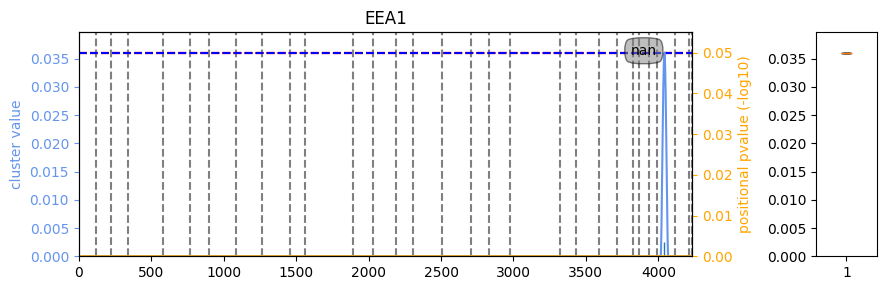

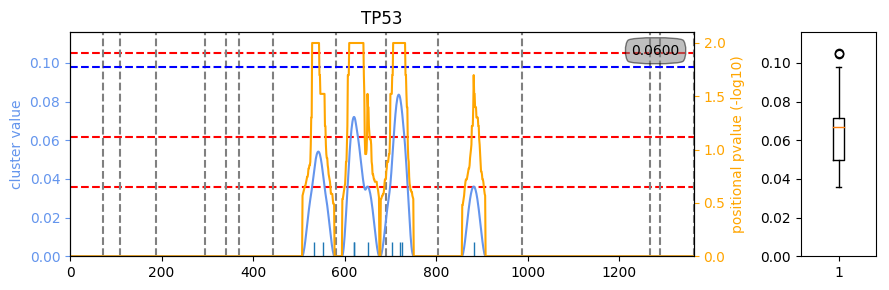

In [14]:
for element in elements:
    plot_clusters(element, results)

### QQ-plot

In [38]:
DRIVERS = set([line.split('\t')[0] for line in open(DRIVERS_FILE, 'r')])


def is_driver(gene):
    return gene in DRIVERS


def qqplot(input_file):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot2grid((1, 1), (0, 0))
    
    df = pd.read_csv(input_file, header=0, sep="\t")
    df = df[np.isfinite(df['PVALUE'])].copy()
    
    y = sorted(df['PVALUE'].map(lambda y: -1 * np.log10(y) if y > 0 else -1 * np.log10(1 / NUM_RANDOMIZATIONS)))
    x = sorted([-1 * np.log10(x) for x in np.linspace(1 / len(y), 1, len(y))])
    
    z = range(int(max(max(y), max(x)) + 1))
    ax.plot(z, z, c='orange')
    ax.scatter(x, y, c='cornflowerblue', alpha=0.5)
    
    df['DRIVER'] = df['SYMBOL'].map(is_driver)
    return df

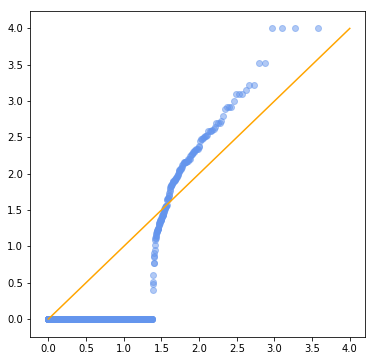

In [39]:
df = qqplot(OUTPUT_FILE)

In [40]:
df.sort_values('PVALUE', inplace=True)
df[df['PVALUE'] <= 0.01]

,SYMBOL,GENEID,PVALUE,MAX_SCORE,DRIVER
5775,SF3B1,ENSG00000115524,0.0000,0.340911,False
266,NSRP1,ENSG00000126653,0.0000,0.272314,False
9116,PIK3CA,ENSG00000121879,0.0000,2.214516,False
3397,AKT1,ENSG00000142208,0.0000,0.511366,False
1332,TP53,ENSG00000141510,0.0003,0.538254,False
7734,KCNV1,ENSG00000164794,0.0003,0.187022,False
6292,USP35,ENSG00000118369,0.0006,0.169052,False
4943,NPHP4,ENSG00000131697,0.0006,0.169052,False
6418,MESDC1,ENSG00000140406,0.0007,0.170455,False
3823,ARHGEF4,ENSG00000136002,0.0008,0.170455,False


## Done!